# Conditional Average Treatment Effects (CATE) with DoWhy and EconML

This is an experimental feature where we use [EconML](https://github.com/microsoft/econml) methods from DoWhy. Using EconML allows CATE estimation using different methods. 

All four steps of causal inference in DoWhy remain the same: model, identify, estimate, and refute. The key difference is that we now call econml methods in the estimation step. There is also a simpler example using linear regression to understand the intuition behind CATE estimators. 

All datasets are generated using linear structural equations.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets

import econml
import warnings
warnings.filterwarnings('ignore')

BETA = 10

keywords are unexpanded, not using


In [3]:
data = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                     num_treatments=1,
                                    treatment_is_binary=False,
                                    num_discrete_common_causes=2,
                                    num_discrete_effect_modifiers=0,
                                    one_hot_encode=False)
df=data['df']
print(df.head())
print("True causal estimate is", data["ate"])

         X0        X1   Z0        Z1        W0        W1 W2 W3         v0  \
0  1.778370  0.524906  1.0  0.408634 -0.656272 -0.518806  1  0  15.229148   
1  1.075402  0.854434  1.0  0.102697 -0.246662 -1.302120  0  1  11.175581   
2  1.455578 -1.563871  1.0  0.832151  0.084182 -0.841832  3  3  26.618584   
3  0.846491  0.364015  1.0  0.736621  0.073486 -1.735504  1  2  19.807255   
4 -0.358799  0.926039  1.0  0.238446 -1.842837 -1.017819  2  0  11.065036   

            y  
0  238.717748  
1  159.153803  
2  347.085040  
3  261.839497  
4  107.041180  
True causal estimate is 11.760911502530618


In [4]:
model = CausalModel(data=data["df"], 
                    treatment=data["treatment_name"], outcome=data["outcome_name"], 
                    graph=data["gml_graph"])

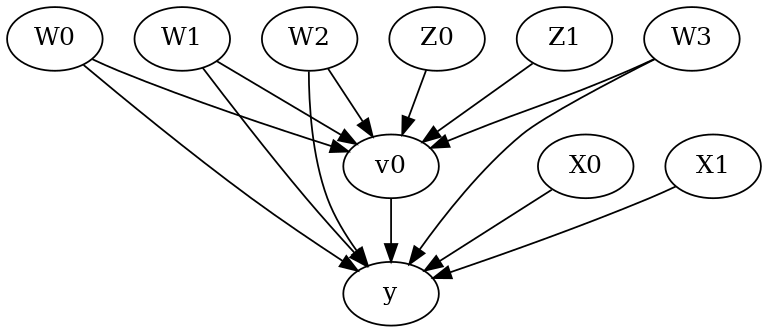

In [5]:
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [6]:
identified_estimand= model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W3,W2,W0,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W2,W0,W1,U) = P(y|v0,W3,W2,W0,W1)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₁  Z₀]    ⎝d[Z₁  Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Linear Model 
First, let us build some intuition using a linear model for estimating CATE. The effect modifiers (that lead to a heterogeneous treatment effect) can be modeled as interaction terms with the treatment. Thus, their value modulates the effect of treatment. 

Below the estimated effect of changing treatment from 0 to 1. 

In [7]:
linear_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="backdoor.linear_regression",
                                       control_value=0,
                                       treatment_value=1)
print(linear_estimate) 

linear_regression


{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['X1', 'X0']}


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W3,W2,W0,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W2,W0,W1,U) = P(y|v0,W3,W2,W0,W1)

## Realized estimand
b: y~v0+W3+W2+W0+W1+v0*X1+v0*X0
Target units: ate

## Estimate
Mean value: 11.760804272599094
### Conditional Estimates
__categorical__X1  __categorical__X0
(-3.167, -0.273]   (-3.145, -0.454]      6.213677
                   (-0.454, 0.128]       8.670868
                   (0.128, 0.628]       10.164205
                   (0.628, 1.227]       11.762805
                   (1.227, 4.394]       14.170066
(-0.273, 0.307]    (-3.145, -0.454]      7.125637
                   (-0.454, 0.128]       9.586559
                   (0.128, 0.628]       11.136660
                   (0.628, 1.227]       12.645990
                   (1.227, 4.394]       15.1844

## EconML methods
We now move to the more advanced methods from the EconML package for estimating CATE.

First, let us look at the double machine learning estimator. Method_name corresponds to the fully qualified name of the class that we want to use. For double ML, it is "econml.dml.DML". 

Target units defines the units over which the causal estimate is to be computed. This can be a lambda function filter on the original dataframe, a new Pandas dataframe, or a string corresponding to the three main kinds of target units ("ate", "att" and "atc"). Below we show an example of a lambda function. 

Method_params are passed directly to EconML. For details on allowed parameters, refer to the EconML documentation. 

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = lambda df: df["X0"]>1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=False)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W3,W2,W0,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W2,W0,W1,U) = P(y|v0,W3,W2,W0,W1)

## Realized estimand
b: y~v0+W3+W2+W0+W1 | X1,X0
Target units: Data subset defined by a function

## Estimate
Mean value: 15.181969477927572
Effect estimates: [15.63984728 13.99646644 12.35703359 ... 14.04519747 14.80293414
 13.38471802]



In [9]:
print("True causal estimate is", data["ate"])

True causal estimate is 11.760911502530618


In [10]:
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = 1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W3,W2,W0,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W2,W0,W1,U) = P(y|v0,W3,W2,W0,W1)

## Realized estimand
b: y~v0+W3+W2+W0+W1 | X1,X0
Target units: 

## Estimate
Mean value: 11.724296099261156
Effect estimates: [15.69595721 14.03887256 12.41610086 ... 10.45915655 13.43374677
 12.64788766]



### CATE Object and Confidence Intervals
EconML provides its own methods to compute confidence intervals. Using BootstrapInference in the example below. 

In [11]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from econml.inference import BootstrapInference
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = "ate",
                                     confidence_intervals=True,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final": LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{
                                                               'inference': BootstrapInference(n_bootstrap_samples=100, n_jobs=-1),
                                                            }
                                              })
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W3,W2,W0,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W2,W0,W1,U) = P(y|v0,W3,W2,W0,W1)

## Realized estimand
b: y~v0+W3+W2+W0+W1 | X1,X0
Target units: ate

## Estimate
Mean value: 11.723704303758991
Effect estimates: [15.70126729 14.03186246 12.48394167 ... 10.4368179  13.45583223
 12.61825153]
95.0% confidence interval: (array([15.81169211, 14.11632092, 12.55743954, ..., 10.39914588,
       13.57131884, 12.62569792]), array([16.09525212, 14.32844649, 12.90200351, ..., 10.58645091,
       13.76424653, 12.83408746]))



### Can provide a new inputs as target units and estimate CATE on them.

In [12]:
test_cols= data['effect_modifier_names'] # only need effect modifiers' values
test_arr = [np.random.uniform(0,1, 10) for _ in range(len(test_cols))] # all variables are sampled uniformly, sample of 10
test_df = pd.DataFrame(np.array(test_arr).transpose(), columns=test_cols)
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = test_df,
                                     confidence_intervals=False,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}
                                              })
print(dml_estimate.cate_estimates)

[10.91763989 11.61138479 13.09666007 12.96491199 11.76470507 10.80753041
 11.73302149 11.12541895 12.16728178 12.88627856]


### Can also retrieve the raw EconML estimator object for any further operations

In [13]:
print(dml_estimate._estimator_object)

## Works with any EconML method
In addition to double machine learning, below we example analyses using orthogonal forests, DRLearner (bug to fix), and neural network-based instrumental variables. 

### Binary treatment, Binary outcome

In [14]:
data_binary = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                    treatment_is_binary=True, outcome_is_binary=True)
# convert boolean values to {0,1} numeric
data_binary['df'].v0 = data_binary['df'].v0.astype(int)
data_binary['df'].y = data_binary['df'].y.astype(int)
print(data_binary['df'])

model_binary = CausalModel(data=data_binary["df"], 
                    treatment=data_binary["treatment_name"], outcome=data_binary["outcome_name"], 
                    graph=data_binary["gml_graph"])
identified_estimand_binary = model_binary.identify_effect(proceed_when_unidentifiable=True)

            X0        X1   Z0        Z1        W0        W1        W2  \
0     0.721432  1.239859  0.0  0.678860  0.113297 -1.218428 -1.940334   
1    -1.013954  0.483581  0.0  0.820913  1.146048  0.075642 -2.349414   
2    -0.358383  2.562335  0.0  0.535139  0.479014 -0.308908 -1.215776   
3     0.265044  2.628512  0.0  0.864545  0.979260 -0.938145 -0.769724   
4    -0.898931  1.864842  0.0  0.181339 -0.859945  0.518561  1.084869   
...        ...       ...  ...       ...       ...       ...       ...   
9995 -0.220231  1.884929  0.0  0.336004  1.718847  0.169575 -2.291468   
9996 -0.855494  0.924505  0.0  0.245825  0.676369 -1.603908 -0.304403   
9997 -0.327293  0.516333  1.0  0.619194  0.865865 -0.919618 -0.791118   
9998 -1.338357  1.252399  0.0  0.487359  0.256002  0.836320 -1.614172   
9999 -3.129553  1.489067  0.0  0.165384  1.478082 -0.504262  0.112664   

            W3  v0  y  
0     0.403198   0  0  
1    -1.053606   0  0  
2     1.927556   1  1  
3    -0.084816   0  0  
4  

#### Using DRLearner estimator

In [15]:
from sklearn.linear_model import LogisticRegressionCV
#todo needs binary y
drlearner_estimate = model_binary.estimate_effect(identified_estimand_binary, 
                                method_name="backdoor.econml.drlearner.LinearDRLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'model_propensity': LogisticRegressionCV(cv=3, solver='lbfgs', multi_class='auto')
                                                    },
                                               "fit_params":{}
                                              })
print(drlearner_estimate)
print("True causal estimate is", data_binary["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W3,W2,W0,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W2,W0,W1,U) = P(y|v0,W3,W2,W0,W1)

## Realized estimand
b: y~v0+W3+W2+W0+W1 | X1,X0
Target units: ate

## Estimate
Mean value: 0.6056964409333128
Effect estimates: [0.74376757 0.59413804 0.79487169 ... 0.63191071 0.63937037 0.56674374]

True causal estimate is 0.3912


### Instrumental Variable Method

In [16]:
import keras
from econml.deepiv import DeepIVEstimator
dims_zx = len(model.get_instruments())+len(model.get_effect_modifiers())
dims_tx = len(model._treatment)+len(model.get_effect_modifiers())
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_zx,)), # sum of dims of Z and X 
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17)])                
response_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_tx,)), # sum of dims of T and X
                                    keras.layers.Dropout(0.17), 
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(1)])

deepiv_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="iv.econml.deepiv.DeepIV",
                                        target_units = lambda df: df["X0"]>-1, 
                                        confidence_intervals=False,
                                method_params={"init_params":{'n_components': 10, # Number of gaussians in the mixture density networks
                                                              'm': lambda z, x: treatment_model(keras.layers.concatenate([z, x])), # Treatment model,
                                                              "h": lambda t, x: response_model(keras.layers.concatenate([t, x])), # Response model
                                                              'n_samples': 1, # Number of samples used to estimate the response
                                                              'first_stage_options': {'epochs':25},
                                                              'second_stage_options': {'epochs':25}
                                                             },
                                               "fit_params":{}})
print(deepiv_estimate)

2022-07-28 10:46:17.469536: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /__t/Python/3.10.5/x64/lib
2022-07-28 10:46:17.469578: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2022-07-28 10:46:19.665905: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /__t/Python/3.10.5/x64/lib
2022-07-28 10:46:19.665946: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-28 10:46:19.665976: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (b7f993127227): /proc/driver/nvidia/version does not exist
2022-07-28 10:46:19.666864: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/25


  1/313 [..............................] - ETA: 4:22 - loss: 137.6634

 26/313 [=>............................] - ETA: 0s - loss: 61.3225   

 51/313 [===>..........................] - ETA: 0s - loss: 34.3987

 78/313 [======>.......................] - ETA: 0s - loss: 24.0427

105/313 [=========>....................] - ETA: 0s - loss: 18.9200

133/313 [===========>..................] - ETA: 0s - loss: 15.7672

160/313 [==============>...............] - ETA: 0s - loss: 13.7457

187/313 [================>.............] - ETA: 0s - loss: 12.2969

214/313 [===================>..........] - ETA: 0s - loss: 11.2026

242/313 [======================>.......] - ETA: 0s - loss: 10.3193

270/313 [========================>.....] - ETA: 0s - loss: 9.6044 

299/313 [===========================>..] - ETA: 0s - loss: 8.9931

313/313 [==============================] - 1s 2ms/step - loss: 8.7347


Epoch 2/25


  1/313 [..............................] - ETA: 1s - loss: 2.9626

 28/313 [=>............................] - ETA: 0s - loss: 3.0491

 56/313 [====>.........................] - ETA: 0s - loss: 2.9409

 83/313 [======>.......................] - ETA: 0s - loss: 2.8146

110/313 [=========>....................] - ETA: 0s - loss: 2.7421

137/313 [============>.................] - ETA: 0s - loss: 2.6760

165/313 [==============>...............] - ETA: 0s - loss: 2.6074

193/313 [=================>............] - ETA: 0s - loss: 2.5622

221/313 [====================>.........] - ETA: 0s - loss: 2.5181

247/313 [======================>.......] - ETA: 0s - loss: 2.4855

271/313 [========================>.....] - ETA: 0s - loss: 2.4616

298/313 [===========================>..] - ETA: 0s - loss: 2.4310

313/313 [==============================] - 1s 2ms/step - loss: 2.4145


Epoch 3/25


  1/313 [..............................] - ETA: 0s - loss: 2.4489

 30/313 [=>............................] - ETA: 0s - loss: 2.1728

 56/313 [====>.........................] - ETA: 0s - loss: 2.1410

 79/313 [======>.......................] - ETA: 0s - loss: 2.1388

101/313 [========>.....................] - ETA: 0s - loss: 2.1258

128/313 [===========>..................] - ETA: 0s - loss: 2.1155

158/313 [==============>...............] - ETA: 0s - loss: 2.1210

187/313 [================>.............] - ETA: 0s - loss: 2.1142

216/313 [===================>..........] - ETA: 0s - loss: 2.1214

243/313 [======================>.......] - ETA: 0s - loss: 2.1178

271/313 [========================>.....] - ETA: 0s - loss: 2.1130

298/313 [===========================>..] - ETA: 0s - loss: 2.1107

313/313 [==============================] - 1s 2ms/step - loss: 2.1082


Epoch 4/25


  1/313 [..............................] - ETA: 1s - loss: 2.1277

 26/313 [=>............................] - ETA: 0s - loss: 2.0037

 51/313 [===>..........................] - ETA: 0s - loss: 2.0030

 75/313 [======>.......................] - ETA: 0s - loss: 2.0183

100/313 [========>.....................] - ETA: 0s - loss: 2.0191

129/313 [===========>..................] - ETA: 0s - loss: 2.0318

156/313 [=============>................] - ETA: 0s - loss: 2.0301

182/313 [================>.............] - ETA: 0s - loss: 2.0275

207/313 [==================>...........] - ETA: 0s - loss: 2.0280

229/313 [====================>.........] - ETA: 0s - loss: 2.0264

254/313 [=======================>......] - ETA: 0s - loss: 2.0275

278/313 [=========================>....] - ETA: 0s - loss: 2.0182

303/313 [============================>.] - ETA: 0s - loss: 2.0215

313/313 [==============================] - 1s 2ms/step - loss: 2.0214


Epoch 5/25


  1/313 [..............................] - ETA: 0s - loss: 2.1436

 26/313 [=>............................] - ETA: 0s - loss: 1.9654

 51/313 [===>..........................] - ETA: 0s - loss: 1.9854

 75/313 [======>.......................] - ETA: 0s - loss: 1.9868

100/313 [========>.....................] - ETA: 0s - loss: 1.9823

124/313 [==========>...................] - ETA: 0s - loss: 1.9752

149/313 [=============>................] - ETA: 0s - loss: 1.9749

176/313 [===============>..............] - ETA: 0s - loss: 1.9701

201/313 [==================>...........] - ETA: 0s - loss: 1.9697

226/313 [====================>.........] - ETA: 0s - loss: 1.9761

252/313 [=======================>......] - ETA: 0s - loss: 1.9751

280/313 [=========================>....] - ETA: 0s - loss: 1.9787

306/313 [============================>.] - ETA: 0s - loss: 1.9796

313/313 [==============================] - 1s 2ms/step - loss: 1.9782


Epoch 6/25


  1/313 [..............................] - ETA: 1s - loss: 1.7470

 28/313 [=>............................] - ETA: 0s - loss: 2.0122

 55/313 [====>.........................] - ETA: 0s - loss: 1.9676

 81/313 [======>.......................] - ETA: 0s - loss: 1.9837

105/313 [=========>....................] - ETA: 0s - loss: 1.9830

129/313 [===========>..................] - ETA: 0s - loss: 1.9901

156/313 [=============>................] - ETA: 0s - loss: 1.9914

180/313 [================>.............] - ETA: 0s - loss: 1.9864

206/313 [==================>...........] - ETA: 0s - loss: 1.9851

233/313 [=====================>........] - ETA: 0s - loss: 1.9787

257/313 [=======================>......] - ETA: 0s - loss: 1.9792

277/313 [=========================>....] - ETA: 0s - loss: 1.9826

304/313 [============================>.] - ETA: 0s - loss: 1.9776

313/313 [==============================] - 1s 2ms/step - loss: 1.9779


Epoch 7/25


  1/313 [..............................] - ETA: 1s - loss: 1.8356

 29/313 [=>............................] - ETA: 0s - loss: 1.9367

 56/313 [====>.........................] - ETA: 0s - loss: 1.9392

 84/313 [=======>......................] - ETA: 0s - loss: 1.9604

109/313 [=========>....................] - ETA: 0s - loss: 1.9528

134/313 [===========>..................] - ETA: 0s - loss: 1.9510

153/313 [=============>................] - ETA: 0s - loss: 1.9527

180/313 [================>.............] - ETA: 0s - loss: 1.9588

208/313 [==================>...........] - ETA: 0s - loss: 1.9558

235/313 [=====================>........] - ETA: 0s - loss: 1.9547

262/313 [========================>.....] - ETA: 0s - loss: 1.9501

289/313 [==========================>...] - ETA: 0s - loss: 1.9427

313/313 [==============================] - 1s 2ms/step - loss: 1.9410


Epoch 8/25


  1/313 [..............................] - ETA: 0s - loss: 1.9652

 27/313 [=>............................] - ETA: 0s - loss: 1.8994

 53/313 [====>.........................] - ETA: 0s - loss: 1.9458

 79/313 [======>.......................] - ETA: 0s - loss: 1.9337

108/313 [=========>....................] - ETA: 0s - loss: 1.9343

137/313 [============>.................] - ETA: 0s - loss: 1.9428

164/313 [==============>...............] - ETA: 0s - loss: 1.9446

189/313 [=================>............] - ETA: 0s - loss: 1.9357

216/313 [===================>..........] - ETA: 0s - loss: 1.9427

244/313 [======================>.......] - ETA: 0s - loss: 1.9383

272/313 [=========================>....] - ETA: 0s - loss: 1.9359

299/313 [===========================>..] - ETA: 0s - loss: 1.9366

313/313 [==============================] - 1s 2ms/step - loss: 1.9379


Epoch 9/25


  1/313 [..............................] - ETA: 1s - loss: 2.0622

 27/313 [=>............................] - ETA: 0s - loss: 1.9103

 54/313 [====>.........................] - ETA: 0s - loss: 1.9250

 82/313 [======>.......................] - ETA: 0s - loss: 1.9298

109/313 [=========>....................] - ETA: 0s - loss: 1.9189

137/313 [============>.................] - ETA: 0s - loss: 1.9213

164/313 [==============>...............] - ETA: 0s - loss: 1.9257

192/313 [=================>............] - ETA: 0s - loss: 1.9262

219/313 [===================>..........] - ETA: 0s - loss: 1.9269

245/313 [======================>.......] - ETA: 0s - loss: 1.9289

272/313 [=========================>....] - ETA: 0s - loss: 1.9252

300/313 [===========================>..] - ETA: 0s - loss: 1.9232

313/313 [==============================] - 1s 2ms/step - loss: 1.9278


Epoch 10/25


  1/313 [..............................] - ETA: 1s - loss: 1.8726

 30/313 [=>............................] - ETA: 0s - loss: 1.8897

 59/313 [====>.........................] - ETA: 0s - loss: 1.8839

 88/313 [=======>......................] - ETA: 0s - loss: 1.8973

116/313 [==========>...................] - ETA: 0s - loss: 1.9006

144/313 [============>.................] - ETA: 0s - loss: 1.9005

172/313 [===============>..............] - ETA: 0s - loss: 1.8981

200/313 [==================>...........] - ETA: 0s - loss: 1.9001

223/313 [====================>.........] - ETA: 0s - loss: 1.8980

249/313 [======================>.......] - ETA: 0s - loss: 1.8989

273/313 [=========================>....] - ETA: 0s - loss: 1.9000

300/313 [===========================>..] - ETA: 0s - loss: 1.9017

313/313 [==============================] - 1s 2ms/step - loss: 1.9016


Epoch 11/25


  1/313 [..............................] - ETA: 1s - loss: 1.9200

 28/313 [=>............................] - ETA: 0s - loss: 1.9272

 56/313 [====>.........................] - ETA: 0s - loss: 1.8910

 85/313 [=======>......................] - ETA: 0s - loss: 1.8969

114/313 [=========>....................] - ETA: 0s - loss: 1.9003

143/313 [============>.................] - ETA: 0s - loss: 1.8892

169/313 [===============>..............] - ETA: 0s - loss: 1.8863

194/313 [=================>............] - ETA: 0s - loss: 1.8796

220/313 [====================>.........] - ETA: 0s - loss: 1.8845

248/313 [======================>.......] - ETA: 0s - loss: 1.8855

276/313 [=========================>....] - ETA: 0s - loss: 1.8897

303/313 [============================>.] - ETA: 0s - loss: 1.8877

313/313 [==============================] - 1s 2ms/step - loss: 1.8877


Epoch 12/25


  1/313 [..............................] - ETA: 1s - loss: 1.7837

 25/313 [=>............................] - ETA: 0s - loss: 1.8446

 49/313 [===>..........................] - ETA: 0s - loss: 1.8814

 76/313 [======>.......................] - ETA: 0s - loss: 1.8765

100/313 [========>.....................] - ETA: 0s - loss: 1.8763

125/313 [==========>...................] - ETA: 0s - loss: 1.8765

153/313 [=============>................] - ETA: 0s - loss: 1.8816

179/313 [================>.............] - ETA: 0s - loss: 1.8760

204/313 [==================>...........] - ETA: 0s - loss: 1.8736

229/313 [====================>.........] - ETA: 0s - loss: 1.8769

253/313 [=======================>......] - ETA: 0s - loss: 1.8740

280/313 [=========================>....] - ETA: 0s - loss: 1.8729

308/313 [============================>.] - ETA: 0s - loss: 1.8772

313/313 [==============================] - 1s 2ms/step - loss: 1.8786


Epoch 13/25


  1/313 [..............................] - ETA: 0s - loss: 1.8068

 28/313 [=>............................] - ETA: 0s - loss: 1.8466

 55/313 [====>.........................] - ETA: 0s - loss: 1.8582

 81/313 [======>.......................] - ETA: 0s - loss: 1.8551

107/313 [=========>....................] - ETA: 0s - loss: 1.8499

133/313 [===========>..................] - ETA: 0s - loss: 1.8583

161/313 [==============>...............] - ETA: 0s - loss: 1.8666

189/313 [=================>............] - ETA: 0s - loss: 1.8657

217/313 [===================>..........] - ETA: 0s - loss: 1.8628

245/313 [======================>.......] - ETA: 0s - loss: 1.8621

272/313 [=========================>....] - ETA: 0s - loss: 1.8649

298/313 [===========================>..] - ETA: 0s - loss: 1.8599

313/313 [==============================] - 1s 2ms/step - loss: 1.8632


Epoch 14/25


  1/313 [..............................] - ETA: 1s - loss: 1.9656

 28/313 [=>............................] - ETA: 0s - loss: 1.8705

 52/313 [===>..........................] - ETA: 0s - loss: 1.8801

 80/313 [======>.......................] - ETA: 0s - loss: 1.8864

109/313 [=========>....................] - ETA: 0s - loss: 1.8759

136/313 [============>.................] - ETA: 0s - loss: 1.8693

163/313 [==============>...............] - ETA: 0s - loss: 1.8648

191/313 [=================>............] - ETA: 0s - loss: 1.8618

218/313 [===================>..........] - ETA: 0s - loss: 1.8608

245/313 [======================>.......] - ETA: 0s - loss: 1.8580

272/313 [=========================>....] - ETA: 0s - loss: 1.8535

296/313 [===========================>..] - ETA: 0s - loss: 1.8536

313/313 [==============================] - 1s 2ms/step - loss: 1.8564


Epoch 15/25


  1/313 [..............................] - ETA: 1s - loss: 1.8070

 28/313 [=>............................] - ETA: 0s - loss: 1.8351

 56/313 [====>.........................] - ETA: 0s - loss: 1.8509

 84/313 [=======>......................] - ETA: 0s - loss: 1.8590

111/313 [=========>....................] - ETA: 0s - loss: 1.8689

139/313 [============>.................] - ETA: 0s - loss: 1.8614

164/313 [==============>...............] - ETA: 0s - loss: 1.8613

190/313 [=================>............] - ETA: 0s - loss: 1.8575

216/313 [===================>..........] - ETA: 0s - loss: 1.8515

244/313 [======================>.......] - ETA: 0s - loss: 1.8520

273/313 [=========================>....] - ETA: 0s - loss: 1.8523

297/313 [===========================>..] - ETA: 0s - loss: 1.8530

313/313 [==============================] - 1s 2ms/step - loss: 1.8516


Epoch 16/25


  1/313 [..............................] - ETA: 1s - loss: 1.9242

 27/313 [=>............................] - ETA: 0s - loss: 1.8597

 53/313 [====>.........................] - ETA: 0s - loss: 1.8521

 80/313 [======>.......................] - ETA: 0s - loss: 1.8453

105/313 [=========>....................] - ETA: 0s - loss: 1.8554

132/313 [===========>..................] - ETA: 0s - loss: 1.8545

159/313 [==============>...............] - ETA: 0s - loss: 1.8571

187/313 [================>.............] - ETA: 0s - loss: 1.8512

215/313 [===================>..........] - ETA: 0s - loss: 1.8457

238/313 [=====================>........] - ETA: 0s - loss: 1.8440

264/313 [========================>.....] - ETA: 0s - loss: 1.8384

291/313 [==========================>...] - ETA: 0s - loss: 1.8406

313/313 [==============================] - 1s 2ms/step - loss: 1.8390


Epoch 17/25


  1/313 [..............................] - ETA: 1s - loss: 2.0382

 31/313 [=>............................] - ETA: 0s - loss: 1.8690

 60/313 [====>.........................] - ETA: 0s - loss: 1.8467

 89/313 [=======>......................] - ETA: 0s - loss: 1.8441

118/313 [==========>...................] - ETA: 0s - loss: 1.8431

147/313 [=============>................] - ETA: 0s - loss: 1.8428

176/313 [===============>..............] - ETA: 0s - loss: 1.8340

205/313 [==================>...........] - ETA: 0s - loss: 1.8272

233/313 [=====================>........] - ETA: 0s - loss: 1.8312

260/313 [=======================>......] - ETA: 0s - loss: 1.8292

288/313 [==========================>...] - ETA: 0s - loss: 1.8315

313/313 [==============================] - 1s 2ms/step - loss: 1.8321


Epoch 18/25


  1/313 [..............................] - ETA: 0s - loss: 1.8184

 30/313 [=>............................] - ETA: 0s - loss: 1.8254

 59/313 [====>.........................] - ETA: 0s - loss: 1.8361

 87/313 [=======>......................] - ETA: 0s - loss: 1.8330

115/313 [==========>...................] - ETA: 0s - loss: 1.8215

144/313 [============>.................] - ETA: 0s - loss: 1.8290

173/313 [===============>..............] - ETA: 0s - loss: 1.8261

202/313 [==================>...........] - ETA: 0s - loss: 1.8219

230/313 [=====================>........] - ETA: 0s - loss: 1.8222

258/313 [=======================>......] - ETA: 0s - loss: 1.8170

285/313 [==========================>...] - ETA: 0s - loss: 1.8199

313/313 [==============================] - ETA: 0s - loss: 1.8197

313/313 [==============================] - 1s 2ms/step - loss: 1.8197


Epoch 19/25


  1/313 [..............................] - ETA: 1s - loss: 1.7688

 27/313 [=>............................] - ETA: 0s - loss: 1.7984

 53/313 [====>.........................] - ETA: 0s - loss: 1.8067

 79/313 [======>.......................] - ETA: 0s - loss: 1.8017

105/313 [=========>....................] - ETA: 0s - loss: 1.7957

129/313 [===========>..................] - ETA: 0s - loss: 1.7992

154/313 [=============>................] - ETA: 0s - loss: 1.8020

181/313 [================>.............] - ETA: 0s - loss: 1.8094

207/313 [==================>...........] - ETA: 0s - loss: 1.8148

233/313 [=====================>........] - ETA: 0s - loss: 1.8160

260/313 [=======================>......] - ETA: 0s - loss: 1.8165

285/313 [==========================>...] - ETA: 0s - loss: 1.8182

311/313 [============================>.] - ETA: 0s - loss: 1.8182

313/313 [==============================] - 1s 2ms/step - loss: 1.8172


Epoch 20/25


  1/313 [..............................] - ETA: 1s - loss: 1.6171

 22/313 [=>............................] - ETA: 0s - loss: 1.7994

 47/313 [===>..........................] - ETA: 0s - loss: 1.8209

 70/313 [=====>........................] - ETA: 0s - loss: 1.8082

 96/313 [========>.....................] - ETA: 0s - loss: 1.7988

123/313 [==========>...................] - ETA: 0s - loss: 1.8094

150/313 [=============>................] - ETA: 0s - loss: 1.8100

177/313 [===============>..............] - ETA: 0s - loss: 1.8105

204/313 [==================>...........] - ETA: 0s - loss: 1.8145

231/313 [=====================>........] - ETA: 0s - loss: 1.8109

258/313 [=======================>......] - ETA: 0s - loss: 1.8102

287/313 [==========================>...] - ETA: 0s - loss: 1.8115

313/313 [==============================] - 1s 2ms/step - loss: 1.8096


Epoch 21/25


  1/313 [..............................] - ETA: 0s - loss: 1.8641

 26/313 [=>............................] - ETA: 0s - loss: 1.8068

 52/313 [===>..........................] - ETA: 0s - loss: 1.7822

 79/313 [======>.......................] - ETA: 0s - loss: 1.7931

106/313 [=========>....................] - ETA: 0s - loss: 1.7927

133/313 [===========>..................] - ETA: 0s - loss: 1.7933

161/313 [==============>...............] - ETA: 0s - loss: 1.7996

187/313 [================>.............] - ETA: 0s - loss: 1.8011

215/313 [===================>..........] - ETA: 0s - loss: 1.8007

243/313 [======================>.......] - ETA: 0s - loss: 1.7973

272/313 [=========================>....] - ETA: 0s - loss: 1.7923

301/313 [===========================>..] - ETA: 0s - loss: 1.7924

313/313 [==============================] - 1s 2ms/step - loss: 1.7935


Epoch 22/25


  1/313 [..............................] - ETA: 1s - loss: 1.9736

 31/313 [=>............................] - ETA: 0s - loss: 1.8045

 59/313 [====>.........................] - ETA: 0s - loss: 1.8109

 86/313 [=======>......................] - ETA: 0s - loss: 1.8058

114/313 [=========>....................] - ETA: 0s - loss: 1.8085

142/313 [============>.................] - ETA: 0s - loss: 1.8141

170/313 [===============>..............] - ETA: 0s - loss: 1.8123

196/313 [=================>............] - ETA: 0s - loss: 1.8105

221/313 [====================>.........] - ETA: 0s - loss: 1.8094

248/313 [======================>.......] - ETA: 0s - loss: 1.8092

273/313 [=========================>....] - ETA: 0s - loss: 1.8061

297/313 [===========================>..] - ETA: 0s - loss: 1.8074

313/313 [==============================] - 1s 2ms/step - loss: 1.8062


Epoch 23/25


  1/313 [..............................] - ETA: 0s - loss: 1.8123

 26/313 [=>............................] - ETA: 0s - loss: 1.7561

 51/313 [===>..........................] - ETA: 0s - loss: 1.7591

 78/313 [======>.......................] - ETA: 0s - loss: 1.7717

104/313 [========>.....................] - ETA: 0s - loss: 1.7729

129/313 [===========>..................] - ETA: 0s - loss: 1.7819

155/313 [=============>................] - ETA: 0s - loss: 1.7864

180/313 [================>.............] - ETA: 0s - loss: 1.7883

202/313 [==================>...........] - ETA: 0s - loss: 1.7918

221/313 [====================>.........] - ETA: 0s - loss: 1.7921

229/313 [====================>.........] - ETA: 0s - loss: 1.7929

246/313 [======================>.......] - ETA: 0s - loss: 1.7945

270/313 [========================>.....] - ETA: 0s - loss: 1.7971

295/313 [===========================>..] - ETA: 0s - loss: 1.7952

313/313 [==============================] - 1s 2ms/step - loss: 1.7911


Epoch 24/25


  1/313 [..............................] - ETA: 1s - loss: 1.9248

 26/313 [=>............................] - ETA: 0s - loss: 1.7988

 54/313 [====>.........................] - ETA: 0s - loss: 1.7713

 83/313 [======>.......................] - ETA: 0s - loss: 1.7653

110/313 [=========>....................] - ETA: 0s - loss: 1.7699

137/313 [============>.................] - ETA: 0s - loss: 1.7710

164/313 [==============>...............] - ETA: 0s - loss: 1.7680

192/313 [=================>............] - ETA: 0s - loss: 1.7693

218/313 [===================>..........] - ETA: 0s - loss: 1.7738

242/313 [======================>.......] - ETA: 0s - loss: 1.7759

266/313 [========================>.....] - ETA: 0s - loss: 1.7755

293/313 [===========================>..] - ETA: 0s - loss: 1.7764

313/313 [==============================] - 1s 2ms/step - loss: 1.7777


Epoch 25/25


  1/313 [..............................] - ETA: 1s - loss: 1.8090

 28/313 [=>............................] - ETA: 0s - loss: 1.8050

 54/313 [====>.........................] - ETA: 0s - loss: 1.8025

 81/313 [======>.......................] - ETA: 0s - loss: 1.7925

109/313 [=========>....................] - ETA: 0s - loss: 1.7830

136/313 [============>.................] - ETA: 0s - loss: 1.7901

163/313 [==============>...............] - ETA: 0s - loss: 1.7797

191/313 [=================>............] - ETA: 0s - loss: 1.7761

218/313 [===================>..........] - ETA: 0s - loss: 1.7756

245/313 [======================>.......] - ETA: 0s - loss: 1.7772

272/313 [=========================>....] - ETA: 0s - loss: 1.7784

301/313 [===========================>..] - ETA: 0s - loss: 1.7752

313/313 [==============================] - 1s 2ms/step - loss: 1.7763


Epoch 1/25


  1/313 [..............................] - ETA: 4:34 - loss: 60776.7578

 21/313 [=>............................] - ETA: 0s - loss: 51737.0664  

 43/313 [===>..........................] - ETA: 0s - loss: 43878.0352

 66/313 [=====>........................] - ETA: 0s - loss: 32655.3789

 89/313 [=======>......................] - ETA: 0s - loss: 26470.8086

108/313 [=========>....................] - ETA: 0s - loss: 23100.7168

128/313 [===========>..................] - ETA: 0s - loss: 20556.2598

148/313 [=============>................] - ETA: 0s - loss: 18738.9727

170/313 [===============>..............] - ETA: 0s - loss: 17118.3477

191/313 [=================>............] - ETA: 0s - loss: 15890.5889

212/313 [===================>..........] - ETA: 0s - loss: 14831.1992

232/313 [=====================>........] - ETA: 0s - loss: 14041.3271

254/313 [=======================>......] - ETA: 0s - loss: 13261.4141

275/313 [=========================>....] - ETA: 0s - loss: 12625.2236

296/313 [===========================>..] - ETA: 0s - loss: 12066.4150

313/313 [==============================] - 2s 2ms/step - loss: 11685.8662


Epoch 2/25


  1/313 [..............................] - ETA: 1s - loss: 4640.4199

 21/313 [=>............................] - ETA: 0s - loss: 4757.7603

 42/313 [===>..........................] - ETA: 0s - loss: 4711.8789

 63/313 [=====>........................] - ETA: 0s - loss: 4700.6079

 85/313 [=======>......................] - ETA: 0s - loss: 4808.7598

107/313 [=========>....................] - ETA: 0s - loss: 4724.2310

129/313 [===========>..................] - ETA: 0s - loss: 4619.9771

150/313 [=============>................] - ETA: 0s - loss: 4727.5981

172/313 [===============>..............] - ETA: 0s - loss: 4654.6670

195/313 [=================>............] - ETA: 0s - loss: 4583.6890

218/313 [===================>..........] - ETA: 0s - loss: 4557.3604

240/313 [======================>.......] - ETA: 0s - loss: 4545.0088

263/313 [========================>.....] - ETA: 0s - loss: 4551.1099

286/313 [==========================>...] - ETA: 0s - loss: 4538.0923

309/313 [============================>.] - ETA: 0s - loss: 4538.4282

313/313 [==============================] - 1s 2ms/step - loss: 4530.1484


Epoch 3/25


  1/313 [..............................] - ETA: 1s - loss: 3533.2769

 23/313 [=>............................] - ETA: 0s - loss: 4242.8286

 45/313 [===>..........................] - ETA: 0s - loss: 4274.9175

 68/313 [=====>........................] - ETA: 0s - loss: 4271.5195

 90/313 [=======>......................] - ETA: 0s - loss: 4261.7036

112/313 [=========>....................] - ETA: 0s - loss: 4252.1753

133/313 [===========>..................] - ETA: 0s - loss: 4229.1206

154/313 [=============>................] - ETA: 0s - loss: 4321.5132

175/313 [===============>..............] - ETA: 0s - loss: 4386.8892

194/313 [=================>............] - ETA: 0s - loss: 4383.6519

215/313 [===================>..........] - ETA: 0s - loss: 4383.5283

235/313 [=====================>........] - ETA: 0s - loss: 4403.1875

259/313 [=======================>......] - ETA: 0s - loss: 4347.7354

283/313 [==========================>...] - ETA: 0s - loss: 4344.7202

306/313 [============================>.] - ETA: 0s - loss: 4386.2817

313/313 [==============================] - 1s 2ms/step - loss: 4394.8242


Epoch 4/25


  1/313 [..............................] - ETA: 1s - loss: 3456.8589

 23/313 [=>............................] - ETA: 0s - loss: 4121.2134

 44/313 [===>..........................] - ETA: 0s - loss: 4199.7524

 65/313 [=====>........................] - ETA: 0s - loss: 4262.3589

 85/313 [=======>......................] - ETA: 0s - loss: 4349.5376

104/313 [========>.....................] - ETA: 0s - loss: 4357.8936

124/313 [==========>...................] - ETA: 0s - loss: 4333.6167

146/313 [============>.................] - ETA: 0s - loss: 4218.8770

169/313 [===============>..............] - ETA: 0s - loss: 4208.1152

191/313 [=================>............] - ETA: 0s - loss: 4229.3706

209/313 [===================>..........] - ETA: 0s - loss: 4230.9570

232/313 [=====================>........] - ETA: 0s - loss: 4210.7847

252/313 [=======================>......] - ETA: 0s - loss: 4200.3438

271/313 [========================>.....] - ETA: 0s - loss: 4155.2896

293/313 [===========================>..] - ETA: 0s - loss: 4168.0425

313/313 [==============================] - ETA: 0s - loss: 4174.2471

313/313 [==============================] - 1s 2ms/step - loss: 4174.2471


Epoch 5/25


  1/313 [..............................] - ETA: 1s - loss: 4317.0571

 23/313 [=>............................] - ETA: 0s - loss: 3844.0356

 45/313 [===>..........................] - ETA: 0s - loss: 3691.9587

 67/313 [=====>........................] - ETA: 0s - loss: 3950.2849

 89/313 [=======>......................] - ETA: 0s - loss: 3982.9263

111/313 [=========>....................] - ETA: 0s - loss: 4104.0210

130/313 [===========>..................] - ETA: 0s - loss: 4101.0630

150/313 [=============>................] - ETA: 0s - loss: 4056.2920

172/313 [===============>..............] - ETA: 0s - loss: 4093.0417

194/313 [=================>............] - ETA: 0s - loss: 4115.4966

216/313 [===================>..........] - ETA: 0s - loss: 4098.0581

235/313 [=====================>........] - ETA: 0s - loss: 4089.2380

252/313 [=======================>......] - ETA: 0s - loss: 4089.4917

271/313 [========================>.....] - ETA: 0s - loss: 4072.5803

288/313 [==========================>...] - ETA: 0s - loss: 4089.9497

309/313 [============================>.] - ETA: 0s - loss: 4096.5161

313/313 [==============================] - 1s 3ms/step - loss: 4096.5898


Epoch 6/25


  1/313 [..............................] - ETA: 1s - loss: 2962.7817

 20/313 [>.............................] - ETA: 0s - loss: 4275.4375

 41/313 [==>...........................] - ETA: 0s - loss: 4390.7598

 63/313 [=====>........................] - ETA: 0s - loss: 4346.9126

 83/313 [======>.......................] - ETA: 0s - loss: 4241.0928

103/313 [========>.....................] - ETA: 0s - loss: 4156.4966

122/313 [==========>...................] - ETA: 0s - loss: 4146.2988

140/313 [============>.................] - ETA: 0s - loss: 4124.2085

160/313 [==============>...............] - ETA: 0s - loss: 4120.1611

179/313 [================>.............] - ETA: 0s - loss: 4106.0918

198/313 [=================>............] - ETA: 0s - loss: 4104.0786

219/313 [===================>..........] - ETA: 0s - loss: 4080.6707

236/313 [=====================>........] - ETA: 0s - loss: 4087.4895

256/313 [=======================>......] - ETA: 0s - loss: 4065.4321

277/313 [=========================>....] - ETA: 0s - loss: 4061.0288

299/313 [===========================>..] - ETA: 0s - loss: 4053.4658

313/313 [==============================] - 1s 3ms/step - loss: 4057.8342


Epoch 7/25


  1/313 [..............................] - ETA: 1s - loss: 4042.5371

 21/313 [=>............................] - ETA: 0s - loss: 4275.5371

 41/313 [==>...........................] - ETA: 0s - loss: 4124.1426

 62/313 [====>.........................] - ETA: 0s - loss: 3908.7253

 84/313 [=======>......................] - ETA: 0s - loss: 4023.0825

106/313 [=========>....................] - ETA: 0s - loss: 4030.7581

127/313 [===========>..................] - ETA: 0s - loss: 4016.8086

148/313 [=============>................] - ETA: 0s - loss: 3971.0225

169/313 [===============>..............] - ETA: 0s - loss: 4021.7688

190/313 [=================>............] - ETA: 0s - loss: 3993.2310

209/313 [===================>..........] - ETA: 0s - loss: 3951.6638

229/313 [====================>.........] - ETA: 0s - loss: 3956.8262

250/313 [======================>.......] - ETA: 0s - loss: 3973.8396

270/313 [========================>.....] - ETA: 0s - loss: 3962.0857

290/313 [==========================>...] - ETA: 0s - loss: 3961.3242

312/313 [============================>.] - ETA: 0s - loss: 3971.5232

313/313 [==============================] - 1s 2ms/step - loss: 3965.8274


Epoch 8/25


  1/313 [..............................] - ETA: 1s - loss: 3695.7771

 24/313 [=>............................] - ETA: 0s - loss: 3614.0159

 47/313 [===>..........................] - ETA: 0s - loss: 3755.7148

 70/313 [=====>........................] - ETA: 0s - loss: 3888.5630

 91/313 [=======>......................] - ETA: 0s - loss: 3959.8489

113/313 [=========>....................] - ETA: 0s - loss: 3922.2659

133/313 [===========>..................] - ETA: 0s - loss: 3960.2007

153/313 [=============>................] - ETA: 0s - loss: 3936.7524

176/313 [===============>..............] - ETA: 0s - loss: 3945.5532

199/313 [==================>...........] - ETA: 0s - loss: 3997.0352

223/313 [====================>.........] - ETA: 0s - loss: 4024.1174

246/313 [======================>.......] - ETA: 0s - loss: 4052.1882

269/313 [========================>.....] - ETA: 0s - loss: 4030.3108

292/313 [==========================>...] - ETA: 0s - loss: 4018.1125

312/313 [============================>.] - ETA: 0s - loss: 3989.3962

313/313 [==============================] - 1s 2ms/step - loss: 3986.7439


Epoch 9/25


  1/313 [..............................] - ETA: 1s - loss: 5244.8862

 21/313 [=>............................] - ETA: 0s - loss: 3740.2009

 40/313 [==>...........................] - ETA: 0s - loss: 4067.0554

 60/313 [====>.........................] - ETA: 0s - loss: 4021.1282

 81/313 [======>.......................] - ETA: 0s - loss: 3913.7568

101/313 [========>.....................] - ETA: 0s - loss: 3938.8591

123/313 [==========>...................] - ETA: 0s - loss: 3916.1326

143/313 [============>.................] - ETA: 0s - loss: 3924.1223

166/313 [==============>...............] - ETA: 0s - loss: 3943.5852

189/313 [=================>............] - ETA: 0s - loss: 3905.5793

212/313 [===================>..........] - ETA: 0s - loss: 3903.7170

230/313 [=====================>........] - ETA: 0s - loss: 3923.5767

251/313 [=======================>......] - ETA: 0s - loss: 3908.9902

273/313 [=========================>....] - ETA: 0s - loss: 3919.0974

292/313 [==========================>...] - ETA: 0s - loss: 3909.8848

312/313 [============================>.] - ETA: 0s - loss: 3914.5881

313/313 [==============================] - 1s 2ms/step - loss: 3918.0652


Epoch 10/25


  1/313 [..............................] - ETA: 1s - loss: 3511.2739

 22/313 [=>............................] - ETA: 0s - loss: 4027.1016

 43/313 [===>..........................] - ETA: 0s - loss: 3899.4563

 65/313 [=====>........................] - ETA: 0s - loss: 3902.0200

 86/313 [=======>......................] - ETA: 0s - loss: 3802.3726

106/313 [=========>....................] - ETA: 0s - loss: 3816.0525

127/313 [===========>..................] - ETA: 0s - loss: 3814.6387

149/313 [=============>................] - ETA: 0s - loss: 3838.0989

169/313 [===============>..............] - ETA: 0s - loss: 3857.4871

192/313 [=================>............] - ETA: 0s - loss: 3868.4939

211/313 [===================>..........] - ETA: 0s - loss: 3940.4277

232/313 [=====================>........] - ETA: 0s - loss: 3930.4829

254/313 [=======================>......] - ETA: 0s - loss: 3970.5083

275/313 [=========================>....] - ETA: 0s - loss: 3947.3137

297/313 [===========================>..] - ETA: 0s - loss: 3966.9634

313/313 [==============================] - 1s 2ms/step - loss: 3965.5818


Epoch 11/25


  1/313 [..............................] - ETA: 1s - loss: 3802.4392

 23/313 [=>............................] - ETA: 0s - loss: 3651.3157

 44/313 [===>..........................] - ETA: 0s - loss: 3782.5342

 66/313 [=====>........................] - ETA: 0s - loss: 3753.3735

 88/313 [=======>......................] - ETA: 0s - loss: 3819.7031

111/313 [=========>....................] - ETA: 0s - loss: 3826.1558

134/313 [===========>..................] - ETA: 0s - loss: 3719.8965

156/313 [=============>................] - ETA: 0s - loss: 3729.9661

179/313 [================>.............] - ETA: 0s - loss: 3769.3325

203/313 [==================>...........] - ETA: 0s - loss: 3819.8513

226/313 [====================>.........] - ETA: 0s - loss: 3848.0828

249/313 [======================>.......] - ETA: 0s - loss: 3863.0601

273/313 [=========================>....] - ETA: 0s - loss: 3861.8352

296/313 [===========================>..] - ETA: 0s - loss: 3875.6052

313/313 [==============================] - 1s 2ms/step - loss: 3870.1267


Epoch 12/25


  1/313 [..............................] - ETA: 1s - loss: 5366.5400

 24/313 [=>............................] - ETA: 0s - loss: 3914.8962

 47/313 [===>..........................] - ETA: 0s - loss: 4072.6140

 69/313 [=====>........................] - ETA: 0s - loss: 4087.6938

 92/313 [=======>......................] - ETA: 0s - loss: 4039.3508

111/313 [=========>....................] - ETA: 0s - loss: 3997.0315

128/313 [===========>..................] - ETA: 0s - loss: 3994.6111

148/313 [=============>................] - ETA: 0s - loss: 3954.7656

166/313 [==============>...............] - ETA: 0s - loss: 3920.3896

186/313 [================>.............] - ETA: 0s - loss: 3894.0979

208/313 [==================>...........] - ETA: 0s - loss: 3888.6858

229/313 [====================>.........] - ETA: 0s - loss: 3858.0698

252/313 [=======================>......] - ETA: 0s - loss: 3897.5745

275/313 [=========================>....] - ETA: 0s - loss: 3885.5928

292/313 [==========================>...] - ETA: 0s - loss: 3915.6489

311/313 [============================>.] - ETA: 0s - loss: 3910.0415

313/313 [==============================] - 1s 2ms/step - loss: 3911.0215


Epoch 13/25


  1/313 [..............................] - ETA: 1s - loss: 2376.3604

 22/313 [=>............................] - ETA: 0s - loss: 4353.5996

 41/313 [==>...........................] - ETA: 0s - loss: 3906.9919

 60/313 [====>.........................] - ETA: 0s - loss: 3878.0991

 76/313 [======>.......................] - ETA: 0s - loss: 3909.4087

 95/313 [========>.....................] - ETA: 0s - loss: 3946.2402

117/313 [==========>...................] - ETA: 0s - loss: 3947.8738

136/313 [============>.................] - ETA: 0s - loss: 3908.4788

154/313 [=============>................] - ETA: 0s - loss: 3919.3560

173/313 [===============>..............] - ETA: 0s - loss: 3950.6858

192/313 [=================>............] - ETA: 0s - loss: 3983.9258

213/313 [===================>..........] - ETA: 0s - loss: 3990.5828

233/313 [=====================>........] - ETA: 0s - loss: 3966.5933

254/313 [=======================>......] - ETA: 0s - loss: 3960.7197

272/313 [=========================>....] - ETA: 0s - loss: 3953.1213

291/313 [==========================>...] - ETA: 0s - loss: 3934.9480

310/313 [============================>.] - ETA: 0s - loss: 3936.2449

313/313 [==============================] - 1s 3ms/step - loss: 3940.2910


Epoch 14/25


  1/313 [..............................] - ETA: 1s - loss: 3734.1104

 21/313 [=>............................] - ETA: 0s - loss: 3914.9382

 39/313 [==>...........................] - ETA: 0s - loss: 3710.9431

 58/313 [====>.........................] - ETA: 0s - loss: 3841.2727

 77/313 [======>.......................] - ETA: 0s - loss: 3851.9595

 99/313 [========>.....................] - ETA: 0s - loss: 3818.4382

120/313 [==========>...................] - ETA: 0s - loss: 3946.9521

143/313 [============>.................] - ETA: 0s - loss: 3957.6714

161/313 [==============>...............] - ETA: 0s - loss: 3930.6104

183/313 [================>.............] - ETA: 0s - loss: 3935.2593

205/313 [==================>...........] - ETA: 0s - loss: 3938.6316

227/313 [====================>.........] - ETA: 0s - loss: 3909.5168

247/313 [======================>.......] - ETA: 0s - loss: 3908.0481

267/313 [========================>.....] - ETA: 0s - loss: 3930.3708

287/313 [==========================>...] - ETA: 0s - loss: 3912.2087

309/313 [============================>.] - ETA: 0s - loss: 3892.4854

313/313 [==============================] - 1s 3ms/step - loss: 3889.6013


Epoch 15/25


  1/313 [..............................] - ETA: 1s - loss: 5882.8232

 23/313 [=>............................] - ETA: 0s - loss: 4148.9038

 46/313 [===>..........................] - ETA: 0s - loss: 3870.3870

 67/313 [=====>........................] - ETA: 0s - loss: 3839.3601

 89/313 [=======>......................] - ETA: 0s - loss: 3859.1809

112/313 [=========>....................] - ETA: 0s - loss: 3842.8188

135/313 [===========>..................] - ETA: 0s - loss: 3805.1467

157/313 [==============>...............] - ETA: 0s - loss: 3775.4136

180/313 [================>.............] - ETA: 0s - loss: 3783.9258

203/313 [==================>...........] - ETA: 0s - loss: 3804.0632

225/313 [====================>.........] - ETA: 0s - loss: 3812.0649

247/313 [======================>.......] - ETA: 0s - loss: 3803.3325

270/313 [========================>.....] - ETA: 0s - loss: 3811.6292

292/313 [==========================>...] - ETA: 0s - loss: 3801.1279

313/313 [==============================] - ETA: 0s - loss: 3822.5994

313/313 [==============================] - 1s 2ms/step - loss: 3822.5994


Epoch 16/25


  1/313 [..............................] - ETA: 1s - loss: 3270.3467

 22/313 [=>............................] - ETA: 0s - loss: 3768.8467

 44/313 [===>..........................] - ETA: 0s - loss: 3771.5393

 67/313 [=====>........................] - ETA: 0s - loss: 3844.2754

 85/313 [=======>......................] - ETA: 0s - loss: 3853.2659

105/313 [=========>....................] - ETA: 0s - loss: 3756.8696

125/313 [==========>...................] - ETA: 0s - loss: 3788.8516

146/313 [============>.................] - ETA: 0s - loss: 3866.3828

164/313 [==============>...............] - ETA: 0s - loss: 3862.1018

184/313 [================>.............] - ETA: 0s - loss: 3857.3335

205/313 [==================>...........] - ETA: 0s - loss: 3857.0137

227/313 [====================>.........] - ETA: 0s - loss: 3845.6875

248/313 [======================>.......] - ETA: 0s - loss: 3830.4353

267/313 [========================>.....] - ETA: 0s - loss: 3843.1348

290/313 [==========================>...] - ETA: 0s - loss: 3840.2432

313/313 [==============================] - ETA: 0s - loss: 3827.8196

313/313 [==============================] - 1s 2ms/step - loss: 3827.8196


Epoch 17/25


  1/313 [..............................] - ETA: 0s - loss: 5256.3711

 24/313 [=>............................] - ETA: 0s - loss: 4083.8896

 45/313 [===>..........................] - ETA: 0s - loss: 3886.9712

 67/313 [=====>........................] - ETA: 0s - loss: 3947.8411

 89/313 [=======>......................] - ETA: 0s - loss: 3916.8213

112/313 [=========>....................] - ETA: 0s - loss: 3869.4802

135/313 [===========>..................] - ETA: 0s - loss: 3826.7720

158/313 [==============>...............] - ETA: 0s - loss: 3853.6570

181/313 [================>.............] - ETA: 0s - loss: 3809.0989

204/313 [==================>...........] - ETA: 0s - loss: 3781.8416

226/313 [====================>.........] - ETA: 0s - loss: 3772.9998

249/313 [======================>.......] - ETA: 0s - loss: 3851.6992

272/313 [=========================>....] - ETA: 0s - loss: 3859.3911

292/313 [==========================>...] - ETA: 0s - loss: 3877.8420

312/313 [============================>.] - ETA: 0s - loss: 3859.9863

313/313 [==============================] - 1s 2ms/step - loss: 3856.3071


Epoch 18/25


  1/313 [..............................] - ETA: 1s - loss: 3194.7493

 21/313 [=>............................] - ETA: 0s - loss: 3685.2783

 42/313 [===>..........................] - ETA: 0s - loss: 3769.3521

 63/313 [=====>........................] - ETA: 0s - loss: 3643.8167

 82/313 [======>.......................] - ETA: 0s - loss: 3719.5503

102/313 [========>.....................] - ETA: 0s - loss: 3652.6074

123/313 [==========>...................] - ETA: 0s - loss: 3641.7959

144/313 [============>.................] - ETA: 0s - loss: 3680.9995

163/313 [==============>...............] - ETA: 0s - loss: 3690.4509

183/313 [================>.............] - ETA: 0s - loss: 3712.0994

202/313 [==================>...........] - ETA: 0s - loss: 3714.4441

221/313 [====================>.........] - ETA: 0s - loss: 3750.0591

241/313 [======================>.......] - ETA: 0s - loss: 3767.8743

261/313 [========================>.....] - ETA: 0s - loss: 3794.3135

282/313 [==========================>...] - ETA: 0s - loss: 3810.2739

301/313 [===========================>..] - ETA: 0s - loss: 3814.0427

313/313 [==============================] - 1s 3ms/step - loss: 3819.4578


Epoch 19/25


  1/313 [..............................] - ETA: 1s - loss: 4107.0718

 22/313 [=>............................] - ETA: 0s - loss: 3622.8318

 43/313 [===>..........................] - ETA: 0s - loss: 3638.1885

 64/313 [=====>........................] - ETA: 0s - loss: 3685.2490

 84/313 [=======>......................] - ETA: 0s - loss: 3638.0029

106/313 [=========>....................] - ETA: 0s - loss: 3730.6074

128/313 [===========>..................] - ETA: 0s - loss: 3766.8367

150/313 [=============>................] - ETA: 0s - loss: 3827.9216

173/313 [===============>..............] - ETA: 0s - loss: 3868.3149

196/313 [=================>............] - ETA: 0s - loss: 3840.9893

217/313 [===================>..........] - ETA: 0s - loss: 3869.9446

237/313 [=====================>........] - ETA: 0s - loss: 3851.9568

255/313 [=======================>......] - ETA: 0s - loss: 3852.2627

275/313 [=========================>....] - ETA: 0s - loss: 3826.0078

296/313 [===========================>..] - ETA: 0s - loss: 3816.7314

313/313 [==============================] - 1s 2ms/step - loss: 3824.2068


Epoch 20/25


  1/313 [..............................] - ETA: 1s - loss: 3669.1272

 21/313 [=>............................] - ETA: 0s - loss: 3651.7869

 42/313 [===>..........................] - ETA: 0s - loss: 3604.1582

 63/313 [=====>........................] - ETA: 0s - loss: 3593.6892

 84/313 [=======>......................] - ETA: 0s - loss: 3610.2463

103/313 [========>.....................] - ETA: 0s - loss: 3693.7371

123/313 [==========>...................] - ETA: 0s - loss: 3685.5457

141/313 [============>.................] - ETA: 0s - loss: 3702.4829

159/313 [==============>...............] - ETA: 0s - loss: 3741.0256

178/313 [================>.............] - ETA: 0s - loss: 3729.1299

197/313 [=================>............] - ETA: 0s - loss: 3744.4541

217/313 [===================>..........] - ETA: 0s - loss: 3803.8865

238/313 [=====================>........] - ETA: 0s - loss: 3845.7417

259/313 [=======================>......] - ETA: 0s - loss: 3834.0496

282/313 [==========================>...] - ETA: 0s - loss: 3852.8767

302/313 [===========================>..] - ETA: 0s - loss: 3852.3391

313/313 [==============================] - 1s 3ms/step - loss: 3851.9241


Epoch 21/25


  1/313 [..............................] - ETA: 1s - loss: 3656.9763

 22/313 [=>............................] - ETA: 0s - loss: 4157.3833

 42/313 [===>..........................] - ETA: 0s - loss: 3832.3252

 63/313 [=====>........................] - ETA: 0s - loss: 3806.8167

 83/313 [======>.......................] - ETA: 0s - loss: 3813.0054

103/313 [========>.....................] - ETA: 0s - loss: 3765.1704

121/313 [==========>...................] - ETA: 0s - loss: 3787.6777

137/313 [============>.................] - ETA: 0s - loss: 3743.9309

155/313 [=============>................] - ETA: 0s - loss: 3819.2612

174/313 [===============>..............] - ETA: 0s - loss: 3792.1450

193/313 [=================>............] - ETA: 0s - loss: 3801.3174

212/313 [===================>..........] - ETA: 0s - loss: 3830.0725

231/313 [=====================>........] - ETA: 0s - loss: 3844.7178

251/313 [=======================>......] - ETA: 0s - loss: 3844.8230

271/313 [========================>.....] - ETA: 0s - loss: 3855.8354

294/313 [===========================>..] - ETA: 0s - loss: 3817.8120

313/313 [==============================] - 1s 3ms/step - loss: 3791.6865


Epoch 22/25


  1/313 [..............................] - ETA: 1s - loss: 4985.4302

 24/313 [=>............................] - ETA: 0s - loss: 3876.1602

 42/313 [===>..........................] - ETA: 0s - loss: 4069.0227

 64/313 [=====>........................] - ETA: 0s - loss: 3932.0791

 86/313 [=======>......................] - ETA: 0s - loss: 3909.5684

107/313 [=========>....................] - ETA: 0s - loss: 3908.9043

126/313 [===========>..................] - ETA: 0s - loss: 3914.1965

147/313 [=============>................] - ETA: 0s - loss: 3904.1868

167/313 [===============>..............] - ETA: 0s - loss: 3850.7661

188/313 [=================>............] - ETA: 0s - loss: 3864.8997

209/313 [===================>..........] - ETA: 0s - loss: 3870.5254

229/313 [====================>.........] - ETA: 0s - loss: 3840.1157

248/313 [======================>.......] - ETA: 0s - loss: 3850.7087

269/313 [========================>.....] - ETA: 0s - loss: 3857.7651

290/313 [==========================>...] - ETA: 0s - loss: 3888.6553

312/313 [============================>.] - ETA: 0s - loss: 3876.7417

313/313 [==============================] - 1s 2ms/step - loss: 3875.8223


Epoch 23/25


  1/313 [..............................] - ETA: 1s - loss: 5026.8130

 24/313 [=>............................] - ETA: 0s - loss: 3856.5244

 46/313 [===>..........................] - ETA: 0s - loss: 3937.9226

 67/313 [=====>........................] - ETA: 0s - loss: 3871.8254

 86/313 [=======>......................] - ETA: 0s - loss: 3806.8862

107/313 [=========>....................] - ETA: 0s - loss: 3771.7219

130/313 [===========>..................] - ETA: 0s - loss: 3771.4641

153/313 [=============>................] - ETA: 0s - loss: 3779.1584

176/313 [===============>..............] - ETA: 0s - loss: 3754.0220

199/313 [==================>...........] - ETA: 0s - loss: 3758.5513

222/313 [====================>.........] - ETA: 0s - loss: 3803.3513

246/313 [======================>.......] - ETA: 0s - loss: 3756.2412

267/313 [========================>.....] - ETA: 0s - loss: 3771.3406

288/313 [==========================>...] - ETA: 0s - loss: 3757.1680

311/313 [============================>.] - ETA: 0s - loss: 3776.6897

313/313 [==============================] - 1s 2ms/step - loss: 3778.4321


Epoch 24/25


  1/313 [..............................] - ETA: 1s - loss: 3800.5188

 23/313 [=>............................] - ETA: 0s - loss: 3694.2197

 45/313 [===>..........................] - ETA: 0s - loss: 3860.7544

 68/313 [=====>........................] - ETA: 0s - loss: 3697.4221

 90/313 [=======>......................] - ETA: 0s - loss: 3756.4333

111/313 [=========>....................] - ETA: 0s - loss: 3757.6082

130/313 [===========>..................] - ETA: 0s - loss: 3745.3069

150/313 [=============>................] - ETA: 0s - loss: 3769.2334

171/313 [===============>..............] - ETA: 0s - loss: 3743.7251

193/313 [=================>............] - ETA: 0s - loss: 3764.2588

215/313 [===================>..........] - ETA: 0s - loss: 3749.5095

235/313 [=====================>........] - ETA: 0s - loss: 3720.0869

256/313 [=======================>......] - ETA: 0s - loss: 3737.8308

277/313 [=========================>....] - ETA: 0s - loss: 3762.1206

299/313 [===========================>..] - ETA: 0s - loss: 3783.1882

313/313 [==============================] - 1s 2ms/step - loss: 3778.3354


Epoch 25/25


  1/313 [..............................] - ETA: 1s - loss: 1856.5388

 14/313 [>.............................] - ETA: 1s - loss: 3844.0176

 33/313 [==>...........................] - ETA: 0s - loss: 3863.2295

 52/313 [===>..........................] - ETA: 0s - loss: 3678.5925

 74/313 [======>.......................] - ETA: 0s - loss: 3787.5747

 96/313 [========>.....................] - ETA: 0s - loss: 3750.1248

117/313 [==========>...................] - ETA: 0s - loss: 3759.5276

138/313 [============>.................] - ETA: 0s - loss: 3743.5471

159/313 [==============>...............] - ETA: 0s - loss: 3738.0701

181/313 [================>.............] - ETA: 0s - loss: 3769.7439

202/313 [==================>...........] - ETA: 0s - loss: 3724.7627

223/313 [====================>.........] - ETA: 0s - loss: 3738.8215

246/313 [======================>.......] - ETA: 0s - loss: 3753.3892

268/313 [========================>.....] - ETA: 0s - loss: 3773.8311

291/313 [==========================>...] - ETA: 0s - loss: 3738.7117

311/313 [============================>.] - ETA: 0s - loss: 3764.8762

313/313 [==============================] - 1s 2ms/step - loss: 3765.2783


The following Variables were used a Lambda layer's call (lambda_7), but
are not present in its tracked objects:
  <tf.Variable 'dense_3/kernel:0' shape=(3, 128) dtype=float32>
  <tf.Variable 'dense_3/bias:0' shape=(128,) dtype=float32>
  <tf.Variable 'dense_4/kernel:0' shape=(128, 64) dtype=float32>
  <tf.Variable 'dense_4/bias:0' shape=(64,) dtype=float32>
  <tf.Variable 'dense_5/kernel:0' shape=(64, 32) dtype=float32>
  <tf.Variable 'dense_5/bias:0' shape=(32,) dtype=float32>
  <tf.Variable 'dense_6/kernel:0' shape=(32, 1) dtype=float32>
  <tf.Variable 'dense_6/bias:0' shape=(1,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


  1/288 [..............................] - ETA: 28s

 49/288 [====>.........................] - ETA: 0s 

 98/288 [=========>....................] - ETA: 0s

147/288 [==============>...............] - ETA: 0s

197/288 [===================>..........] - ETA: 0s

245/288 [========================>.....] - ETA: 0s

286/288 [============================>.] - ETA: 0s

288/288 [==============================] - 0s 1ms/step


  1/288 [..............................] - ETA: 5s

 46/288 [===>..........................] - ETA: 0s

 83/288 [=======>......................] - ETA: 0s

128/288 [============>.................] - ETA: 0s

176/288 [=================>............] - ETA: 0s

224/288 [======================>.......] - ETA: 0s

273/288 [===========================>..] - ETA: 0s

288/288 [==============================] - 0s 1ms/step


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₁  Z₀]    ⎝d[Z₁  Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

## Realized estimand
b: y~v0+W3+W2+W0+W1 | X1,X0
Target units: Data subset defined by a function

## Estimate
Mean value: -1.8314090967178345
Effect estimates: [-2.3718796  -2.9206543  -2.7475586  ...  0.66666794 -3.0020523
  0.03886795]



### Metalearners

In [17]:
data_experiment = dowhy.datasets.linear_dataset(BETA, num_common_causes=5, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=5,
                                    treatment_is_binary=True, outcome_is_binary=False)
# convert boolean values to {0,1} numeric
data_experiment['df'].v0 = data_experiment['df'].v0.astype(int)
print(data_experiment['df'])
model_experiment = CausalModel(data=data_experiment["df"], 
                    treatment=data_experiment["treatment_name"], outcome=data_experiment["outcome_name"], 
                    graph=data_experiment["gml_graph"])
identified_estimand_experiment = model_experiment.identify_effect(proceed_when_unidentifiable=True)

            X0        X1        X2        X3        X4   Z0        Z1  \
0     1.253902 -0.104105  0.174251 -0.751787  0.692720  1.0  0.276321   
1     1.195487 -1.481951 -0.964104 -0.345177 -1.627723  1.0  0.819904   
2     0.488895  0.247879 -0.396826  0.234458  0.246762  1.0  0.739122   
3    -0.174855 -0.037949 -0.482860  0.133952 -1.196951  1.0  0.619203   
4    -0.148632  0.219186 -1.893235  0.212277 -0.631648  1.0  0.467150   
...        ...       ...       ...       ...       ...  ...       ...   
9995 -1.389572 -0.591998 -3.007353  0.756718  0.058354  1.0  0.094734   
9996  0.490848 -1.204797  0.522802  1.153488 -1.771565  1.0  0.556174   
9997  0.393447 -0.789272  0.374892 -0.553593 -1.628922  1.0  0.896481   
9998 -0.282533  0.509201 -1.740232  1.525513 -2.483706  1.0  0.841020   
9999 -1.797538  0.533200  0.701658  2.330947  0.015580  1.0  0.621197   

            W0        W1        W2        W3        W4  v0          y  
0    -0.195909  0.076866 -1.877120 -1.807746  1.106

In [18]:
from sklearn.ensemble import RandomForestRegressor
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'models': RandomForestRegressor()
                                                    },
                                               "fit_params":{}
                                              })
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W3,W2,W0,W1,W4])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W2,W0,W1,W4,U) = P(y|v0,W3,W2,W0,W1,W4)

## Realized estimand
b: y~v0+X2+X0+X4+X1+X3+W3+W2+W0+W1+W4
Target units: ate

## Estimate
Mean value: 5.795373465055928
Effect estimates: [12.22385313 -1.27918282 13.08287555 ...  7.28551994 -0.28570934
 18.78931598]

True causal estimate is 3.323641937773397


## Avoiding retraining the estimator 

Once an estimator is fitted, it can be reused to estimate effect on different data points. In this case, you can pass `fit_estimator=False` to `estimate_effect`. This works for any EconML estimator. We show an example for the T-learner below.

In [19]:
# For metalearners, need to provide all the features (except treatmeant and outcome)
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                fit_estimator=False,
                                target_units=data_experiment["df"].drop(["v0","y", "Z0", "Z1"], axis=1)[9995:],                        
                                method_params={})
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W3,W2,W0,W1,W4])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W2,W0,W1,W4,U) = P(y|v0,W3,W2,W0,W1,W4)

## Realized estimand
b: y~v0+X2+X0+X4+X1+X3+W3+W2+W0+W1+W4
Target units: Data subset provided as a data frame

## Estimate
Mean value: 12.824952147250652
Effect estimates: [ 6.91907214 19.88744776 16.12683623  8.33758742 12.85381718]

True causal estimate is 3.323641937773397


## Refuting the estimate

### Adding a random common cause variable

In [20]:
res_random=model.refute_estimate(identified_estimand, dml_estimate, method_name="random_common_cause")
print(res_random)

Refute: Add a random common cause
Estimated effect:11.907483300092192
New effect:11.890502991723425
p value:0.45999999999999996



### Adding an unobserved common cause variable

In [21]:
res_unobserved=model.refute_estimate(identified_estimand, dml_estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="linear", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(res_unobserved)

Refute: Add an Unobserved Common Cause
Estimated effect:11.907483300092192
New effect:11.858620740025657



### Replacing treatment with a random (placebo) variable

In [22]:
res_placebo=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=10 # at least 100 is good, setting to 10 for speed 
        ) 
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:11.907483300092192
New effect:-0.00033082658436696806
p value:0.49796550848106125



### Removing a random subset of the data

In [23]:
res_subset=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="data_subset_refuter", subset_fraction=0.8,
        num_simulations=10)
print(res_subset)

Refute: Use a subset of data
Estimated effect:11.907483300092192
New effect:11.858580716543003
p value:0.08207532342734425



More refutation methods to come, especially specific to the CATE estimators.